In [1]:
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import tqdm
import xarray as xr

import radtran

The layers in OBS and RAD are documented on the usgs website [here](https://lpdaac.usgs.gov/products/emitl1bradv001/).

In [2]:
# Open a NetCDF file
emit_obs_ds = xr.open_dataset("/home/azureuser/tmp/EMIT_L1B_OBS_001_20240801T111930_2421408_009.nc")
emit_rad_ds = xr.open_dataset("/home/azureuser/tmp/EMIT_L1B_RAD_001_20240801T111930_2421408_009.nc")

## Sensor band parameters

In [3]:
from netCDF4 import Dataset

In [4]:
nc = Dataset("/home/azureuser/tmp/EMIT_L1B_RAD_001_20240801T111930_2421408_009.nc")

In [5]:
nc.groups.keys()

dict_keys(['sensor_band_parameters', 'location'])

In [6]:
sensor_band_parameters = xr.open_dataset(
    "/home/azureuser/tmp/EMIT_L1B_RAD_001_20240801T111930_2421408_009.nc", group="sensor_band_parameters"
)

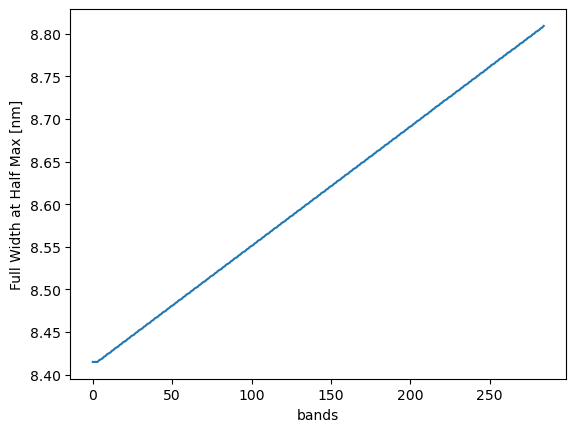

In [7]:
sensor_band_parameters["fwhm"].plot();

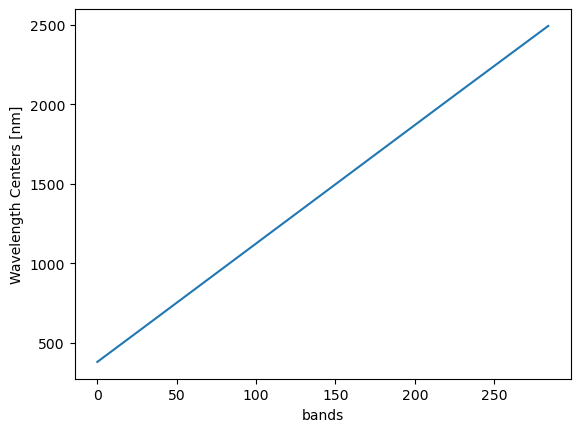

In [8]:
sensor_band_parameters["wavelengths"].plot();

In [9]:
# Largest to-sensor zenith. It turns out EMIT is *not* always at nadir.
emit_obs_ds["obs"].isel(bands=2).max().item()

10.754545211791992

In [10]:
# Largest to-sun zenith (degrees from nadir|)
emit_obs_ds["obs"].isel(bands=4).max().item()

18.632144927978516

In [11]:
gamma = 1 / np.cos(np.deg2rad(emit_obs_ds["obs"].isel(bands=2))) + 1 / np.cos(
    np.deg2rad(emit_obs_ds["obs"].isel(bands=4))
)

Text(0.5, 1.0, 'gamma')

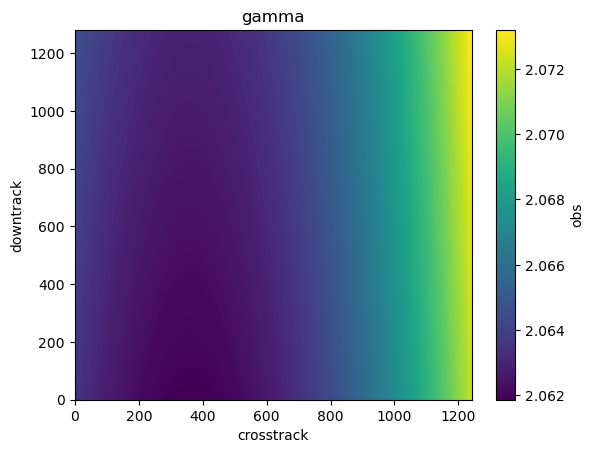

In [12]:
gamma.plot()
plt.title("gamma")

## Radiance

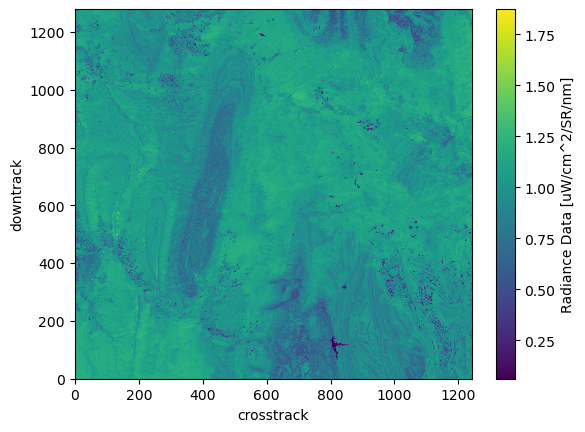

In [13]:
band248_radiances = emit_rad_ds["radiance"].isel(bands=248)
band248_radiances.plot()

## Getting EMIT absorption spectrum

In [14]:
from pydantic import AnyUrl

In [15]:
aux_data_path = "../../radtran/data/aux_data"
hapi_data_path = AnyUrl(
    "azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/data/radtran/hapi/v1.1.1.0/",
)
instrument = "EMIT"
band = "VSWIR"
T = 300
p = 1.013

- works but doesn't cache: `azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/data/radtran/hapi/v1.1.1.0/Sentinel2A/B11/abs_CH4_hapi_Sentinel2A_band_B11.npy`
- doesn't work without extra credential params: `abfs://azureml-blobstore-23d8394c-3e7f-44e2-bbca-6906690a5f6d/data/radtran/hapi/v1.1.1.0/Sentinel2A/B11/abs_CH4_hapi_Sentinel2A_band_B11.npy`

In [16]:
CH4_absorption = radtran.filter_functions.get_absorption_cross_section_vector(
    T, p, instrument, band, "CH4", hapi_data_path
)

Text(0, 0.5, 'Cross section (cm/#)')

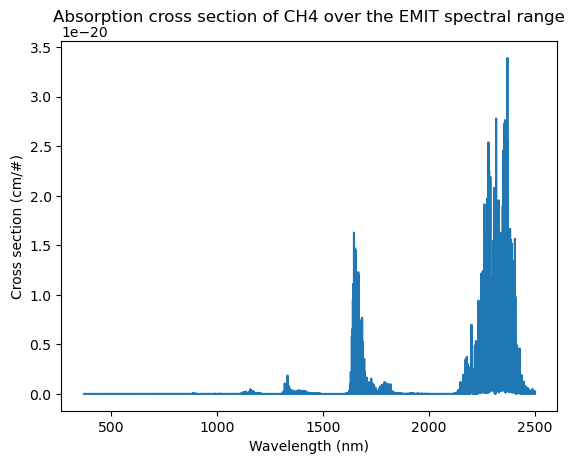

In [17]:
plt.plot(CH4_absorption.wavelength, CH4_absorption.response)
plt.title("Absorption cross section of CH4 over the EMIT spectral range", pad=14)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross section (cm/#)")

In [18]:
narrow_range = (2215, 2240)

(0.0, 1e-20)

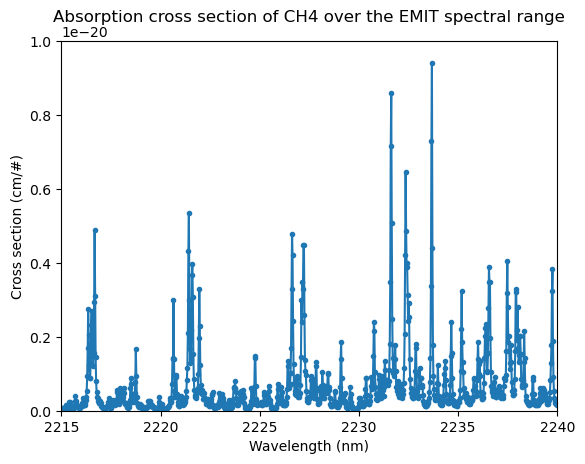

In [19]:
plt.plot(CH4_absorption.wavelength, CH4_absorption.response, ".-")
plt.title("Absorption cross section of CH4 over the EMIT spectral range", pad=14)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross section (cm/#)")
plt.xlim(narrow_range)
plt.ylim(0, 1e-20)

# Solar, H20, CO2 filters

In [20]:
solar_filter = radtran.filter_functions.generate_solar_filter(hapi_data_path, aux_data_path, instrument, band)

(0.0, 100000000.0)

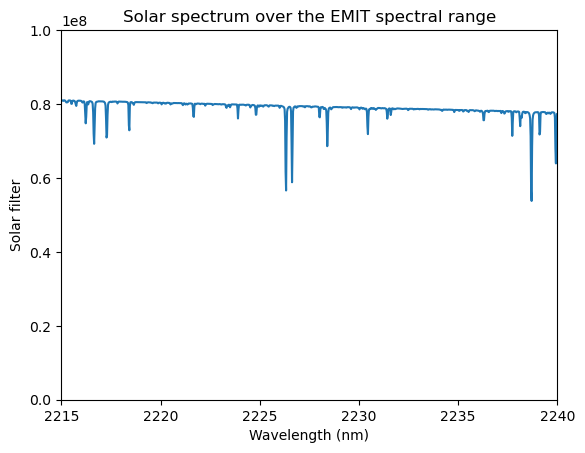

In [21]:
plt.plot(solar_filter.wavelength, solar_filter.response)
plt.title("Solar spectrum over the EMIT spectral range")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Solar filter")
plt.xlim(narrow_range)
plt.ylim(0, 1e8)

The solar spectrum is reasonably flat within a band, which suggests we can ignore it. We'll test this below.

In [22]:
h2o_concentration = radtran.utils.constants.h2o_concentration
h2o_filter = radtran.filter_functions.generate_absorbing_species_filter(
    T, p, instrument, hapi_data_path, band, "H20", h2o_concentration
)

(0.0, 1.0)

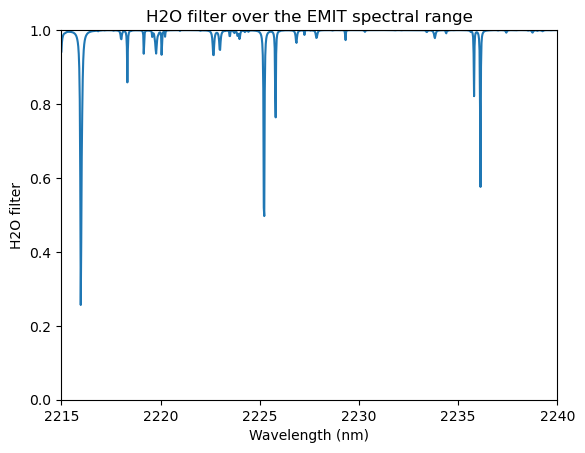

In [23]:
plt.plot(h2o_filter.wavelength, h2o_filter.response)
plt.title("H2O filter over the EMIT spectral range")
plt.xlabel("Wavelength (nm)")
plt.ylabel("H2O filter")
plt.xlim(narrow_range)
plt.ylim(0, 1)

## Spectral response function of each band

For each band, NASA seems to use a "Gaussian Spectral Response Function (SRF) with a FWHM given by φ1." Let's work this out.

In [24]:
# find a band in our selected narrow range
iband = np.argmin(np.abs(sensor_band_parameters["wavelengths"].values - 2225))

In [25]:
band_center_nm = sensor_band_parameters["wavelengths"][iband].item()
band_fwhm_nm = sensor_band_parameters["fwhm"][iband].item()
band_center_nm, band_fwhm_nm

(2226.719482421875, 8.758000373840332)

In [26]:
%%time
# convert FWHM to sigma
# https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/
sigma2 = band_fwhm_nm**2 / (8 * np.log(2))
gaussian_srf = np.exp(-((solar_filter.wavelength - band_center_nm) ** 2) / (2 * sigma2))
gaussian_srf = radtran.filter_functions.SpectralFilter(wavelength=solar_filter.wavelength, response=gaussian_srf)

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.75 ms


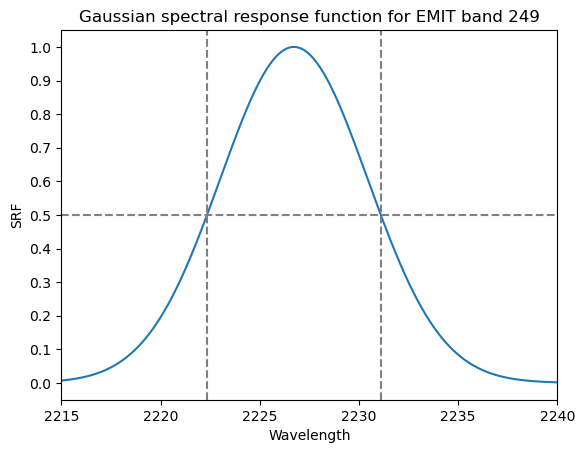

In [27]:
plt.plot(gaussian_srf.wavelength, gaussian_srf.response)
plt.title(f"Gaussian spectral response function for EMIT band {iband+1}")
plt.xlabel("Wavelength")
plt.ylabel("SRF")
plt.xlim(narrow_range)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.5, linestyle="--", color="grey")
plt.axvline(band_center_nm - band_fwhm_nm / 2, linestyle="--", color="grey")
plt.axvline(band_center_nm + band_fwhm_nm / 2, linestyle="--", color="grey")

## Normalized brightness for a single band and concentration

In [28]:
from scipy.special import logsumexp, expm1

In [29]:
%%time
example_concentration_molm2 = 0.5  # Units: mol/m2
m2_to_cm2 = radtran.utils.constants.m2_to_cm2  # Units: cm2/m2
mol_to_N = radtran.utils.constants.mol_to_N  # Units: #/mol
example_gamma = 2.08

# absorption spectrum has units cm2/#
# So example_concentration_molm2*mol_to_N/m2_to_cm2*CH4_absorption
# has units: mol/m2  #/mol m2/cm2 cm2 / # = unitless
# (which is what we want)

# a more numerically stable implementation of
# np.log(np.sum(gaussian_srf * np.exp(-example_gamma*example_concentration_molm2*mol_to_N/m2_to_cm2*CH4_absorption.response))
band_window = gaussian_srf.response > 1e-3
lse = logsumexp(
    a=-example_gamma * example_concentration_molm2 * mol_to_N / m2_to_cm2 * CH4_absorption.response[band_window],
    b=gaussian_srf.response[band_window],
)
# normalize by the sum of the sensor response function
# denom = gaussian_srf.sum()
logdenom = logsumexp(a=0.0, b=gaussian_srf.response[band_window])
normalized_brightness = np.exp(lse - logdenom)
print(f"{100*(1-normalized_brightness):.1f}% of light is absorbed by methane.")
normalized_brightness

3.6% of light is absorbed by methane.
CPU times: user 727 µs, sys: 162 µs, total: 889 µs
Wall time: 692 µs


0.9635770001254641

In [30]:
%%time
# including the solar filter and H2O makes hardly any difference, as expected

example_concentration_molm2 = 0.5  # Units: mol/m2
m2_to_cm2 = radtran.utils.constants.m2_to_cm2  # Units: cm2/m2
mol_to_N = radtran.utils.constants.mol_to_N  # Units: #/mol
example_gamma = 2.08

# absorption spectrum has units cm2/#
# So example_concentration_molm2*mol_to_N/m2_to_cm2*CH4_absorption
# has units: mol/m2  #/mol m2/cm2 cm2 / # = unitless
# (which is what we want)

# a more numerically stable implementation of
# np.log(np.sum(gaussian_srf * np.exp(-example_gamma*example_concentration_molm2*mol_to_N/m2_to_cm2*CH4_absorption.response))
global_filter = solar_filter * gaussian_srf * (h2o_filter**example_gamma)
global_filter /= global_filter.response.max()
band_window = global_filter.response > 1e-3
lse = logsumexp(
    a=-example_gamma * example_concentration_molm2 * mol_to_N / m2_to_cm2 * CH4_absorption.response[band_window],
    b=global_filter.response[band_window],
)
# normalize by the sum of the sensor response function
# denom = gaussian_srf.sum()
logdenom = logsumexp(a=0.0, b=global_filter.response[band_window])
normalized_brightness = np.exp(lse - logdenom)
print(f"{100*(1-normalized_brightness):.1f}% of light is absorbed by methane.")
normalized_brightness

3.6% of light is absorbed by methane.
CPU times: user 1.79 ms, sys: 376 µs, total: 2.16 ms
Wall time: 1.87 ms


0.9635993093039572

## Normalized brightness for all bands and an array of concentrations

In [31]:
from xarray_einstats.stats import logsumexp

In [32]:
def precompute_log_norm_brightness(
    sensor_band_parameters: xr.DataArray,
    CH4_absorption: xr.DataArray,
    gamma_concentration: Sequence[float],
) -> xr.DataArray:
    """
    Precompute logarithmic normalized brightness values for methane absorption,
    using the Beer-Lambert law.

    Parameters
    ----------
    sensor_band_parameters : xr.DataArray
        Sensor specifications including:
        - 'fwhm': Full Width at Half Maximum for each band
        - 'wavelengths': Central wavelength for each band
    CH4_absorption : xr.DataArray
        Methane absorption cross-sections with wavelength coordinates
        in the same units as used in sensor_band_parameters.
        Units: cm/#
    gamma_concentration : Sequence[float]
        Sequence of concentration values to compute absorption for.
        Units: mol/m2

    Returns
    -------
    xr.DataArray
        Logarithmic normalized brightness values for each band and concentration.
        Dimensions: (gamma_concentration, bands)

    Notes
    -----
    The calculation uses the following steps:
    1. Creates Gaussian SRF using sensor parameters
    2. Applies Beer-Lambert law with numerical stability using logsumexp
    3. Normalizes by the sum of the spectral response function

    The final result represents log(I/I₀) where:
    - I is the intensity after absorption
    - I₀ is the initial intensity

    Uses mol_to_N and m2_to_cm2 constants imported from external module.
    """
    # Create wavelength DataArray
    wavelength_da = xr.DataArray(CH4_absorption.wavelength, coords={"wavelength": CH4_absorption.wavelength})

    # Calculate Gaussian spectral response function parameters
    sigma2 = sensor_band_parameters["fwhm"] ** 2 / (8 * np.log(2))
    all_bands_gaussian_srf = np.exp(-((wavelength_da - sensor_band_parameters["wavelengths"]) ** 2) / (2 * sigma2))

    # Create gamma concentration dimension
    gamma_concentration = pd.Index(gamma_concentration, name="gamma_concentration")

    # Implement the Beer-Lambert law in a numerically stable manner
    lse = [
        logsumexp(-gc * mol_to_N / m2_to_cm2 * CH4_absorption, dims=["wavelength"], b=all_bands_gaussian_srf)
        for gc in tqdm.tqdm(gamma_concentration)
    ]
    lse = xr.concat(lse, dim=gamma_concentration)

    # Normalize by spectral response function
    logdenom = np.log(all_bands_gaussian_srf.sum(dim="wavelength"))
    log_normalized_brightness = lse - logdenom

    return log_normalized_brightness

In [33]:
%%time
CH4_absorption_da = xr.DataArray(CH4_absorption.response, coords={"wavelength": CH4_absorption.wavelength})
log_normalized_brightness = precompute_log_norm_brightness(
    sensor_band_parameters,
    CH4_absorption_da,
    gamma_concentration=2 * np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0]),
)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.71it/s]

CPU times: user 3.03 s, sys: 1.18 s, total: 4.21 s
Wall time: 4.21 s


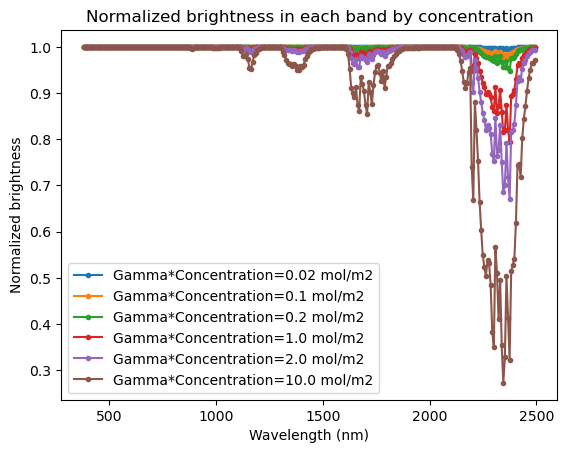

In [34]:
for gc in log_normalized_brightness.gamma_concentration:
    plt.plot(
        sensor_band_parameters["wavelengths"],
        np.exp(log_normalized_brightness.sel(gamma_concentration=gc)),
        ".-",
        label=f"Gamma*Concentration={gc.item()} mol/m2",
    )
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized brightness")
plt.title(f"Normalized brightness in each band by concentration")
plt.legend()

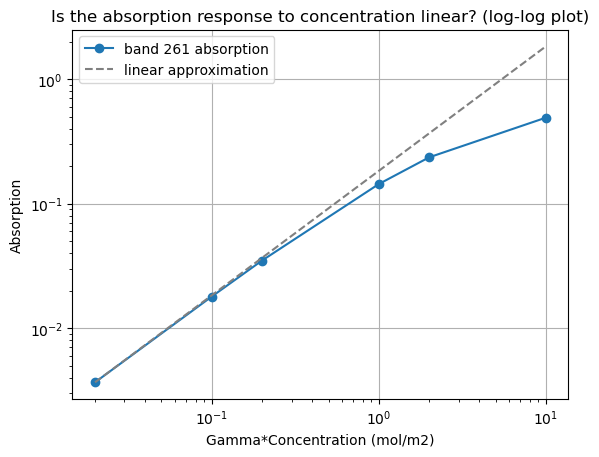

In [35]:
y = (-expm1(log_normalized_brightness)).isel(bands=260)
y.plot(label="band 261 absorption", marker="o")
plt.xscale("log")
plt.yscale("log")
plt.title("Is the absorption response to concentration linear? (log-log plot)")
plt.xlabel("Gamma*Concentration (mol/m2)")
plt.ylabel("Absorption")
x0 = y.gamma_concentration[0]
xN = y.gamma_concentration[-1]
y0 = y.isel(gamma_concentration=0)
plt.plot([x0, xN], [y0, y0 * xN / x0], linestyle="--", color="grey", label="linear approximation")
plt.legend()
plt.grid()

# Add plumes to an EMIT scene

In [36]:
import logging

logging.getLogger("azure").setLevel(logging.CRITICAL)

In [37]:
from src.utils.utils import initialize_clients

ml_client, _, _, s3_client = initialize_clients(force_msi=False)

Found the config file in: /config.json


In [ ]:
from src.validation.detection_probability import (
    load_gorrono_plumes,
    crop_enhancements,
    randomly_position_sim_plume,
)

In [39]:
gorrono_plumes = load_gorrono_plumes(ml_client)
gorrono_plumes = crop_enhancements(gorrono_plumes)

gorrono_plumes_uri: azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/orbio-data/methane_enhancements_molpercm2


Text(0.5, 1.0, 'Single plume (mol/m2)')

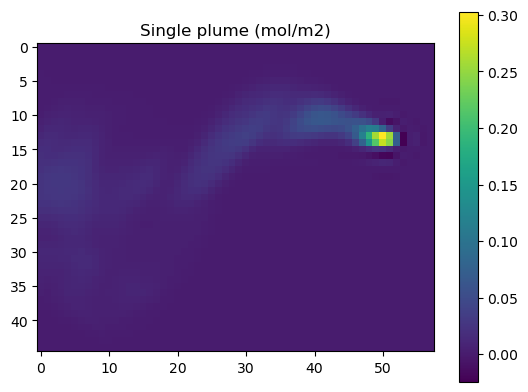

In [40]:
plt.imshow(gorrono_plumes[0] * 1e4)
plt.colorbar()
plt.title("Single plume (mol/m2)")

In [ ]:
rng = np.random.default_rng(42)
enhancement = gorrono_plumes[0]
single_band = emit_rad_ds["radiance"].isel(bands=200)  # select arbitrary band
(
    methane_enhancement_molpercm2,
    methane_enhancement_mask,
    _,
) = randomly_position_sim_plume(
    sim_plumes=[(gorrono_plumes[i], gorrono_plumes[i] > 0) for i in rng.integers(4, size=50)],
    tile_band=single_band,
    exclusion_mask_plumes=single_band * 0,  # no cloud mask
    rng=rng,
)

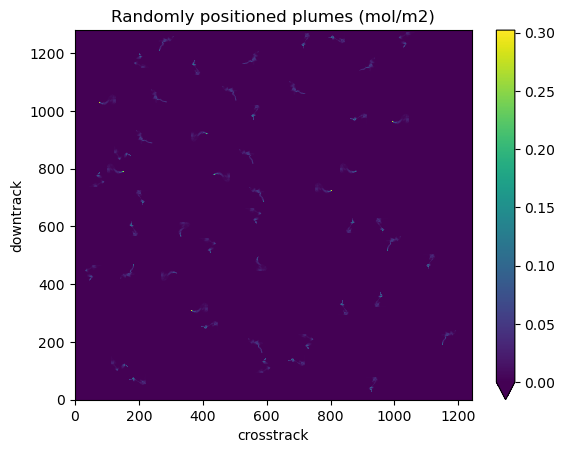

In [42]:
enhancement_da = xr.DataArray(methane_enhancement_molpercm2, coords=emit_rad_ds["radiance"].isel(bands=0).coords)
xr.plot.imshow(enhancement_da * 10000, vmin=0)
plt.title("Randomly positioned plumes (mol/m2)");

# Modify the band values

In [43]:
def interpolate_normalized_brightness(
    gamma_concentration: np.ndarray,
    log_nB_table_for_band: xr.DataArray,
) -> np.ndarray:
    """
    Interpolate normalized brightness values for methane pixels using a lookup table.

    Parameters
    ----------
    gamma_concentration : np.ndarray
        Array of gamma * concentration values for pixels with methane present,
        where concentration is in mol/m².
    log_nB_table_for_band : xr.DataArray
        Log-normalized brightness values indexed by gamma_concentration for a specific band.

    Returns
    -------
    np.ndarray
        Interpolated normalized brightness values for the input pixels.
    """
    absorption = -np.expm1(log_nB_table_for_band)
    return -np.expm1(
        np.interp(
            np.log(gamma_concentration),
            np.log(absorption.gamma_concentration),
            np.log(absorption),
        )
    )


def compute_normalized_brightness(
    gamma: xr.DataArray,
    concentration: xr.DataArray,
    log_nB_table: xr.DataArray,
) -> xr.DataArray:
    """
    Interpolate normalized brightness values for each band based on methane concentration.

    For pixels containing methane (where gamma * concentration > minimum threshold),
    this function interpolates band-specific normalized brightness values using a
    pre-computed lookup table. For all other pixels, the normalized brightness is 1.0
    (indicating no absorption).

    Bands with negligible methane absorption (maximum absorption < 1e-5) are skipped
    and their normalized brightness values remain at 1.0.

    Parameters
    ----------
    gamma: xr.DataArray
        The gamma value for each pixel. Gamma is the path length multiplier
        for light traveling through the atmosphere, calculated as:
        1/cos(theta_sun) + 1/cos(theta_sensor)
        where theta_sun is the solar zenith angle
        and theta_sensor is the sensor zenith angle.
    concentration : xr.DataArray
        Methane concentration values in mol/m². Must have same spatial dimensions
        as gamma. Values > 0 indicate presence of methane.
    log_nB_table : xr.DataArray
        Pre-computed lookup table of log-normalized brightness values. Has dimensions
        'bands' and 'gamma_concentration', where gamma_concentration is the product
        of gamma and methane concentration in mol/m².

    Returns
    -------
    xr.DataArray
        The normalized brightness values for each band and pixel. Has the same spatial
        dimensions as the input arrays plus a 'bands' dimension. Values are between
        0 and 1, where:
        - 1.0 indicates no absorption (either no methane or band insensitive to methane)
        - < 1.0 indicates absorption, with smaller values meaning stronger absorption
    """
    # Identify pixels with methane
    gamma_concentration = gamma * concentration
    lower_threshold = log_nB_table.gamma_concentration.min().item()
    methane_pixels = gamma_concentration > lower_threshold
    methane_gamma_concentrations = gamma_concentration.values[methane_pixels]

    # Initialize an array to store normalized brightness
    nB = xr.DataArray(
        np.ones((*concentration.shape, len(log_nB_table.bands)), dtype=float),
        dims=[*concentration.dims, "bands"],
        coords={**concentration.coords, "bands": log_nB_table.bands},
    )

    # Process each band separately
    for band in tqdm.tqdm(log_nB_table.bands.values):
        # Skip bands with negligible methane absorption
        if -np.expm1(log_nB_table.sel(bands=band).min()) < 1e-5:
            continue

        nB_methane_pixels = interpolate_normalized_brightness(
            methane_gamma_concentrations, log_nB_table.sel(bands=band)
        )

        # Sanity checks
        assert nB_methane_pixels.min() > 0
        assert nB_methane_pixels.max() <= 1

        # Create a temporary array to hold the full raster for this band
        nB_raster = np.ones(concentration.shape)
        nB_raster[methane_pixels] = nB_methane_pixels

        # Assign the raster to the band in the output DataArray
        nB.loc[dict(bands=band)] = nB_raster

    logging.info(f"Biggest reduction factor: {nB.min().item():.4f}")
    return nB

In [44]:
%%time
enhancement_da = m2_to_cm2 * xr.DataArray(
    methane_enhancement_molpercm2, coords=emit_rad_ds["radiance"].isel(bands=0).coords
)
normalized_brightness_allbands = compute_normalized_brightness(gamma, enhancement_da, log_normalized_brightness)

100%|████████████████████████████████████████████████████████████████████████████| 285/285 [00:08<00:00, 35.57it/s]
2025-01-06 14:17:16,171 - INFO - Biggest reduction factor: 0.8629


CPU times: user 8.44 s, sys: 942 ms, total: 9.38 s
Wall time: 9.35 s


In [45]:
%%time
modified_radiance = emit_rad_ds["radiance"] * normalized_brightness_allbands

CPU times: user 1.59 s, sys: 2.04 s, total: 3.63 s
Wall time: 3.61 s


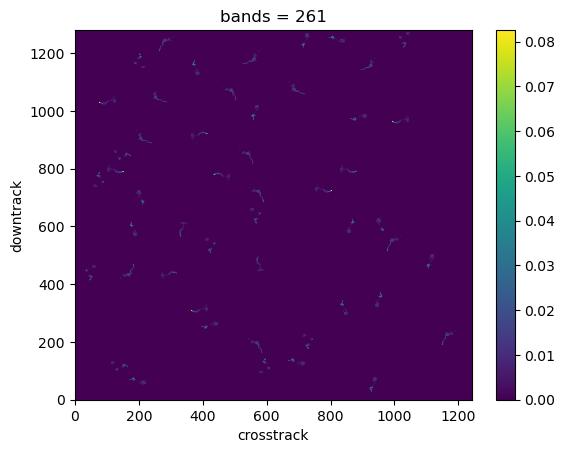

In [46]:
xr.plot.imshow(1 - modified_radiance.sel(bands=261) / emit_rad_ds["radiance"].sel(bands=261))